#Install Dependencies

_(Remember to choose GPU in Runtime if not already selected. Runtime --> Change Runtime Type --> Hardware accelerator --> GPU)_

In [ ]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard fbe67e465375231474a2ad80a4389efc77ecff99

Cloning into 'yolov5'...
remote: Enumerating objects: 15305, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 15305 (delta 0), reused 4 (delta 0), pack-reused 15300
Receiving objects: 100% (15305/15305), 14.19 MiB | 30.65 MiB/s, done.
Resolving deltas: 100% (10493/10493), done.
/content/yolov5/yolov5
HEAD is now at fbe67e4 Fix `OMP_NUM_THREADS=1` for macOS (#8624)


In [ ]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

^C
Setup complete. Using torch 1.13.1+cu116 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40)


# Download Correctly Formatted Custom Dataset 

We'll download our dataset from Roboflow. Use the "**YOLOv5 PyTorch**" export format. Note that the Ultralytics implementation calls for a YAML file defining where your training and test data is. The Roboflow export also writes this format for us.

To get your data into Roboflow, follow the [Getting Started Guide](https://blog.roboflow.ai/getting-started-with-roboflow/).

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key=your key)
project = rf.workspace("akanksha").project("wild_animal_detection")
dataset = project.version(1).download("yolov5")



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Wild_Animal_Detection-1 in yolov5pytorch:: 100%|██████████| 1859/1859 [00:01<00:00, 1580.75it/s]


In [ ]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat {dataset.location}/data.yaml

names:
- '0'
- '1'
- '2'
- '3'
nc: 4
roboflow:
  license: Private
  project: wild_animal_detection
  url: https://app.roboflow.com/project/wild_animal_detection/1
  version: 1
  workspace: project
test: ../test/images
train: Wild_Animal_Detection-1/train/images
val: Wild_Animal_Detection-1/valid/images


# Define Model Configuration and Architecture

We will write a yaml script that defines the parameters for our model like the number of classes, anchors, and each layer.

You do not need to edit these cells, but you may.

In [ ]:
# define number of classes based on YAML
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [ ]:
%cd /content/
with open('yolov5/models/custom_yolov5s.yaml','w') as f:
  print('custom model config written')

/content
custom model config written


# Train Custom YOLOv5 Detector

### Next, we'll fire off training!


Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive [folder](https://drive.google.com/open?id=1Drs_Aiu7xx6S-ix95f9kNsA6ueKRpN2J))
- **name:** result names
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training

In [ ]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 100 --data {dataset.location}/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/yolov5
train: weights=, cfg=./models/custom_yolov5s.yaml, data=/content/yolov5/yolov5/Wild_Animal_Detection-1/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 484 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v6.1-306-gfbe67e4 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momen

#Run Inference  With Trained Weights
Run inference with a pretrained checkpoint on contents of `test/images` folder downloaded from Roboflow.

In [ ]:
# trained weights are saved by default in our weights folder
%ls runs/

detect/  train/


In [ ]:
%ls runs/train/yolov5s_results3/weights

best.pt  last.pt


In [ ]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# use the best weights!
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results3/weights/best.pt --img 416 --conf 0.4 --source /content/yolov5/Wild_Animal_Detection-1/test/images/

/content/yolov5
detect: weights=['runs/train/yolov5s_results3/weights/best.pt'], source=/content/yolov5/Wild_Animal_Detection-1/test/images/, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-306-gfbe67e4 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 232 layers, 7254609 parameters, 0 gradients, 16.8 GFLOPs
image 1/92 /content/yolov5/Wild_Animal_Detection-1/test/images/1677_jpg.rf.e11eb79212011cbdcba83c841825d150.jpg: 416x416 1 Deer, Done. (0.014s)
image 2/92 /content/yolov5/Wild_Animal_Detection-1/test/images/1678_jpg.rf.74bf9274c55f370ada6dab868604bc6d.jpg: 416x416 1 Deer, Done. (0.022s)
im

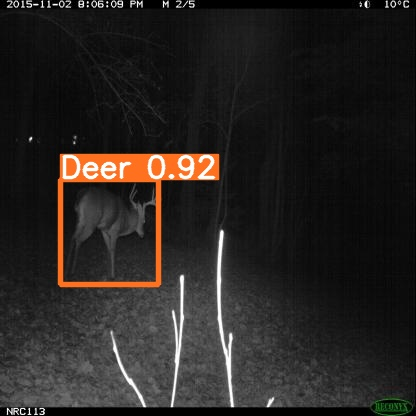

In [ ]:
#display inference on ALL test images
#this looks much better with longer training above

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp3/1677_jpg.rf.e11eb79212011cbdcba83c841825d150.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

In [ ]:
!python detect.py --weights /runs/train/yolov5s_results3/weights/best.pt --img 416 --conf 0.4 --source 1

detect: weights=['/runs/train/yolov5s_results3/weights/best.pt'], source=1, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-306-gfbe67e4 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

Traceback (most recent call last):
  File "/content/yolov5/detect.py", line 256, in <module>
    main(opt)
  File "/content/yolov5/detect.py", line 251, in main
    run(**vars(opt))
  File "/usr/local/lib/python3.9/dist-packages/torch/autograd/grad_mode.py", line 27, in decorate_context
    return func(*args, **kwargs)
  File "/content/yolov5/detect.py", line 92, in run
    model = DetectMultiBackend(weights, device=device, dnn=dnn, data=data, fp16=ha

# Export Trained Weights for Future Inference

Now that you have trained your custom detector, you can export the trained weights you have made here for inference on your device elsewhere

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
%cp /content/yolov5/runs/train/yolov5s_results/weights/best.pt /content/gdrive/My\ Drive